In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from sklearn.mixture import GaussianMixture
from sklearn import datasets, mixture
import xarray, dask
%matplotlib inline

In [200]:
ncfile1 = './NATL_HOMOGENEOUS_variables_7subset_1.nc'
nc1 = Dataset(ncfile1, 'r')
ncfile2 = './NATL_HOMOGENEOUS_variables_7subset_7.nc'
nc2 = Dataset(ncfile2, 'r')
print(nc1.variables.keys())

odict_keys(['DEPTH', 'LATITUDE', 'LONGITUDE', 'TIME', 'DBINDEX', 'TEMP', 'PSAL', 'SIG0', 'BRV2'])


On importe les données du premier .nc

In [33]:
TIME1=nc1.variables['TIME'][:]
LAT1=nc1.variables['LATITUDE'][:]
LON1=nc1.variables['LONGITUDE'][:]
PSAL1=nc1.variables['PSAL'][:]
z=nc1.variables['DEPTH'][:]

Plot de tous les points disponibles 

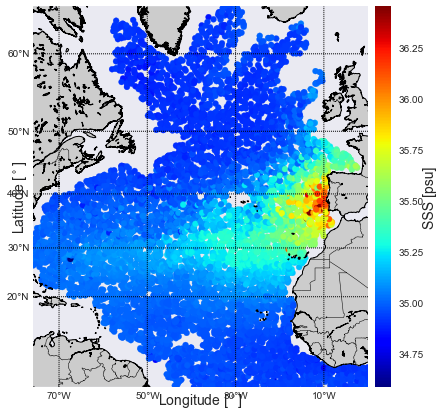

In [4]:
plt.figure(figsize=(9,7))
map = Basemap(llcrnrlon=LON1.min(),llcrnrlat=LAT1.min(),urcrnrlon=LON1.max(),urcrnrlat=LAT1.max(),
resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(20,90,10)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(-90,40,20)
map.drawmeridians(meridians,labels=[True,False,False,True])
x,y=map(LON1,LAT1)
sc=map.scatter(x,y,PSAL1[:,-1],c=PSAL1[:,-1],cmap='jet')
cbar = map.colorbar(sc,location='right')
cbar.set_label("SSS [psu]", labelpad=-1,fontsize=14)
plt.xlabel('Longitude [$^\circ$]',Fontsize=14)
plt.ylabel('Latitude [$^\circ$]',Fontsize=14)
plt.xticks()
plt.show()

### Selection profiles

On selectionne les profiles près de la sortie de la Méditerranée

In [36]:
lat_min=25
lat_max=45
lon_min=-30
lon_max=0


idx1=np.where((LAT1<lat_max) & (LAT1>lat_min) & (LON1<lon_max) & (LON1>lon_min))
LAT_new1=LAT1[idx1]
LON_new1=LON1[idx1]
PSAL_new1=PSAL1[idx1]

nz=z.shape[0]
nb1=idx1[0].shape[0]

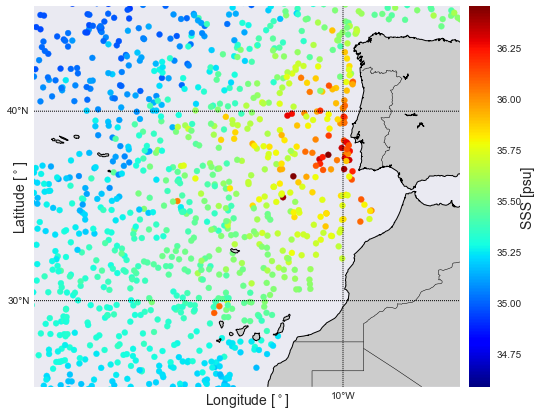

In [8]:
plt.figure(figsize=(9,7))
map = Basemap(llcrnrlon=LON_new1.min(),llcrnrlat=LAT_new1.min(),urcrnrlon=LON_new1.max(),urcrnrlat=LAT_new1.max(),
resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(20,90,10)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(-90,40,20)
map.drawmeridians(meridians,labels=[True,False,False,True])
x,y=map(LON1,LAT1)
sc=map.scatter(x,y,PSAL1[:,-1],c=PSAL1[:,-1],cmap='jet')
cbar = map.colorbar(sc,location='right')
cbar.set_label("SSS [psu]", labelpad=-1,fontsize=14)
plt.xlabel('Longitude [$^\circ$]',Fontsize=14)
plt.ylabel('Latitude [$^\circ$]',Fontsize=14)
plt.xticks()
plt.show()

In [11]:
PSAL_new1[0,:].shape

(282,)

Plot de tous les profiles avec moyenne et std

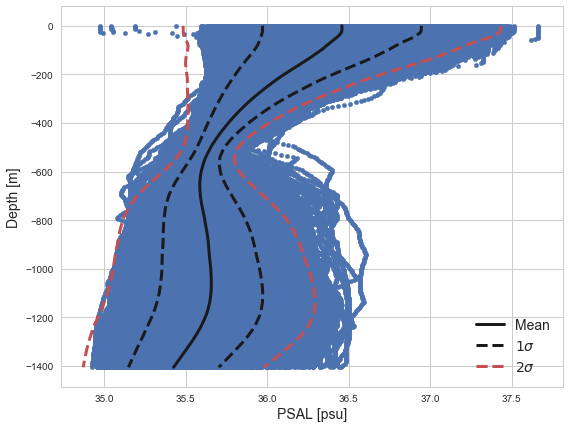

In [54]:
MEAN=np.mean(PSAL_new1[0:nb1,:],axis=0)
STD=np.std(PSAL_new1[0:nb1,:],axis=0)
col_SAL=np.linspace(PSAL_new1.min(),PSAL_new1.max(),282)

plt.figure(figsize=(9,7))
for i in range(0,nb1):
    sc=plt.scatter(PSAL_new1[i,:],z,s=20,c='b')
plt.plot(MEAN,z,linewidth=3,c='k',label='Mean')  
plt.plot(MEAN+STD,z,'--',c='k',label=r'$1\sigma$',linewidth=3)
plt.plot(MEAN-STD,z,'--',c='k',linewidth=3) 
plt.plot(MEAN+2*STD,z,'--',c='r',label=r'$2\sigma$',linewidth=3) 
plt.plot(MEAN-2*STD,z,'--',c='r',linewidth=3) 
plt.legend(fontsize=14)
plt.xlabel('PSAL [psu]',fontsize=14)
plt.ylabel('Depth [m]',fontsize=14)
plt.show()

## PDF

On choisit deux dimensions, i.e. deux niveaux de profondeur.
Un à 500m où la deviation de salinité est faible et un où l'on pense trouver les meddies

In [441]:
z1=-500
z2=-1200
z_idx1=np.where(z==z1)[0][0]
z_idx2=np.where(z==z2)[0][0]

D1=np.array((PSAL_new1[:,z_idx1],PSAL_new1[:,z_idx2])).T

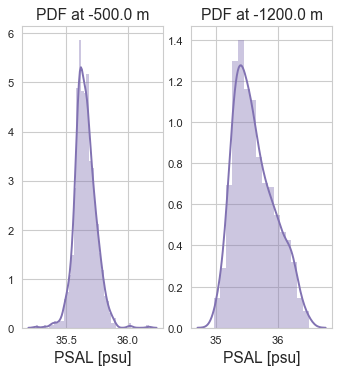

In [442]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", palette="deep", color_codes=True)
plt.subplot(121)
sns.distplot(PSAL_new1[:,z_idx1], norm_hist=True, color="m")
plt.xlabel('PSAL [psu]',fontsize=14)
plt.title('PDF at '+str(z[z_idx1])+' m',fontsize=14)

plt.subplot(122)
sns.distplot(PSAL_new1[:,z_idx2], norm_hist=True, color="m")
plt.xlabel('PSAL [psu]',fontsize=14)
plt.title('PDF at '+str(z[z_idx2])+' m',fontsize=14)
plt.show()

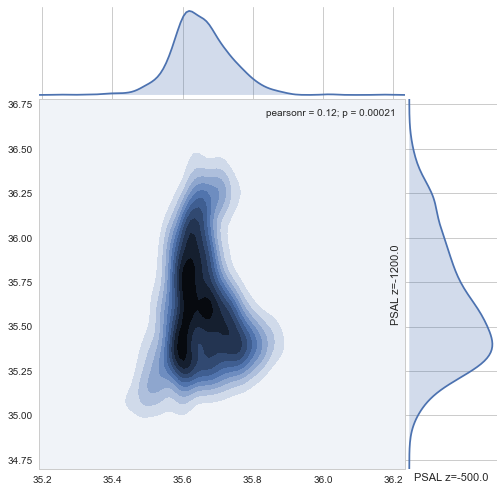

In [443]:
x = PSAL_new1[:,z_idx1]
y = PSAL_new1[:,z_idx2]
sns.set(context="notebook",style="whitegrid", color_codes=True)
sns.jointplot(x=x, y=y, kind="kde",size=7, ratio=4, space=0)
plt.xlabel('PSAL z='+str(z[z_idx1]))
plt.ylabel('PSAL z='+str(z[z_idx2]))
plt.show()

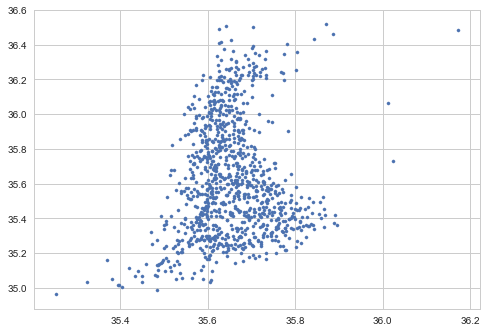

In [444]:
plt.scatter(D1[:,0],D1[:,1],s=10)
plt.show()

On cherche le nombre de clusters optimal.
Donne 5 mais la recherche est plus facile avec N=3

In [447]:
n_K=10
nb_K=np.arange(1,n_K+1)
B=np.zeros(n_K)
for i in range(1,n_K):
    GMM=mixture.GaussianMixture(n_components=i)
    GMM=GMM.fit(D1)
    B[i]=GMM.bic(D1)

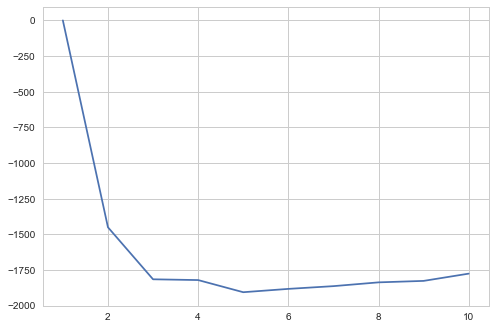

In [448]:
plt.plot(nb_K,B)
plt.show()

In [485]:
K=3

# Init the GMM
gmm1=mixture.GaussianMixture(n_components=K)

# Fit the GMM onto the dataset
gmm1=gmm1.fit(D1)

print(gmm1.score(D1))

# print optimised parameters of the modes
k=0
for pos1, covar1, w1 in zip(gmm1.means_,gmm1.covariances_,gmm1.weights_):
    print('\nMode/Class/Component/Cluster ID#',k)
    print('Center:\n',pos1)
    print('Covariance:\n',covar1)
    print('Weight (prior):\n',w1)
    k=k+1

0.975094042961

Mode/Class/Component/Cluster ID# 0
Center:
 [ 35.66402668  35.32785592]
Covariance:
 [[ 0.01240246  0.00888099]
 [ 0.00888099  0.0178837 ]]
Weight (prior):
 0.402706784442

Mode/Class/Component/Cluster ID# 1
Center:
 [ 35.65031986  36.08639848]
Covariance:
 [[ 0.00432038  0.00633107]
 [ 0.00633107  0.03293811]]
Weight (prior):
 0.232648600123

Mode/Class/Component/Cluster ID# 2
Center:
 [ 35.64363341  35.64290403]
Covariance:
 [[ 0.00306723 -0.00029629]
 [-0.00029629  0.02275431]]
Weight (prior):
 0.364644615435


In [450]:
# Get the posteriors
posts1=gmm1.predict_proba(D1)
print(posts1.shape)

# get the class maximising the posteriors (hard classif):
labels1=gmm1.predict(D1)
print(labels1.shape)

# Compute robustness of the classification
robust1=(np.max(posts1,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id1=np.digitize(robust1,Plist)-1

i_sample=np.random.randint(0,high=D1.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts1[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts1[i_sample,:]))
print('Class id of the sample:',labels1[i_sample])
#print('Robustess of the classification:',round(robust[i_sample]*100,1),"% i.e.",row10[robust_id[i_sample]])

(994, 3)
(994,)

Posteriors for 1 sample: [[  0.    57.61  42.39]] in %
Sum of the posteriors: 1.0
Class id of the sample: [1]


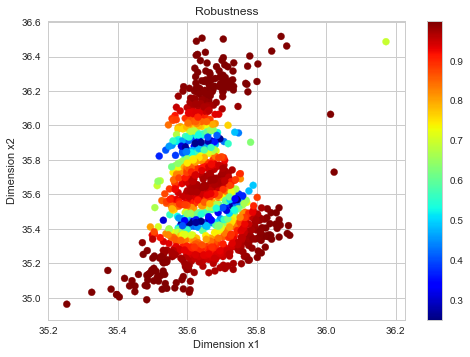

In [451]:
plt.scatter(D1[:,0],D1[:,1],c=robust1,cmap='jet')
plt.colorbar()
plt.title('Robustness')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

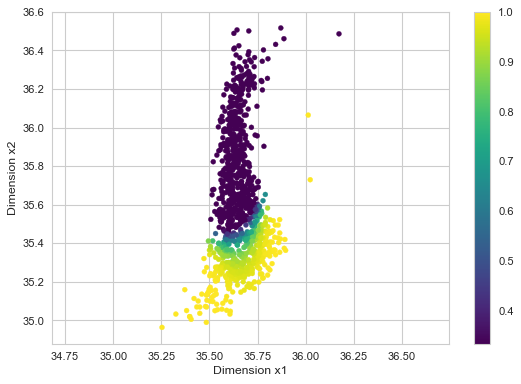

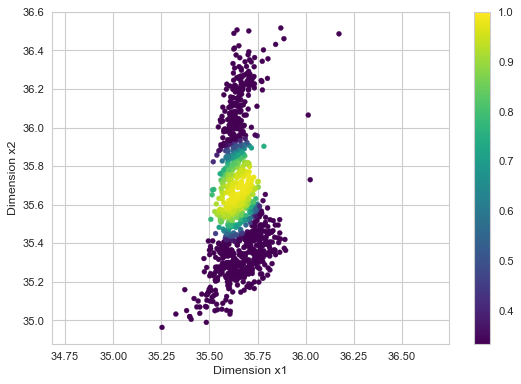

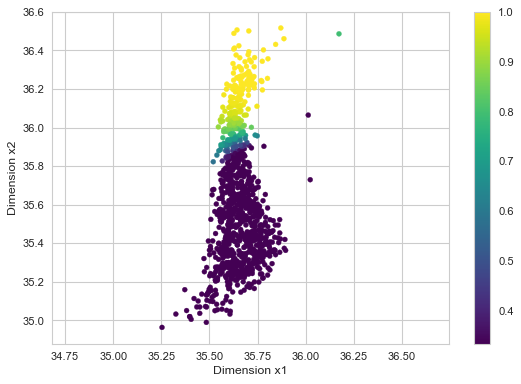

In [452]:
for ik in np.arange(K):
    fig,ax=plt.subplots(nrows=1,ncols=1,dpi=80,facecolor='w',edgecolor='k',sharey=True)
    
    sc=ax.scatter(D1[:,0],D1[:,1],c=posts1[:,ik],s=20,cmap='viridis',vmin=1./K,vmax=1)
    plt.axis('equal')
    plt.colorbar(sc)
    plt.xlabel('Dimension x1')
    plt.ylabel('Dimension x2')

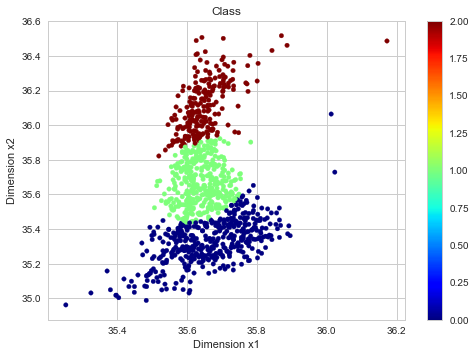

In [453]:
sc=plt.scatter(D1[:,0],D1[:,1],s=20,c=labels1,cmap='jet')
plt.colorbar(sc)
plt.title('Class')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

## Classify new data

In [454]:
N=100
x1,x2=np.linspace(34,37,N), np.linspace(34,37,N)
X,Y=np.meshgrid(x1,x2)
X,Y=np.ravel(X),np.ravel(Y)
D_new=np.array((X,Y)).T

posts_new=gmm1.predict_proba(D_new)
labels_new=gmm1.predict(D_new)
robust_new=(np.max(posts_new,axis=1)-1./K)*K/(K-1.)

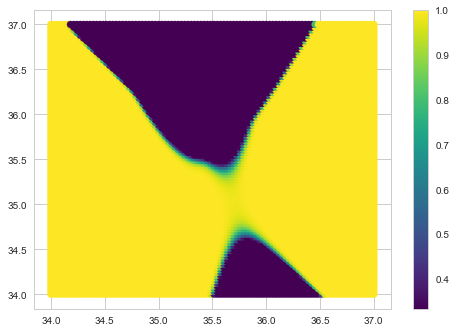

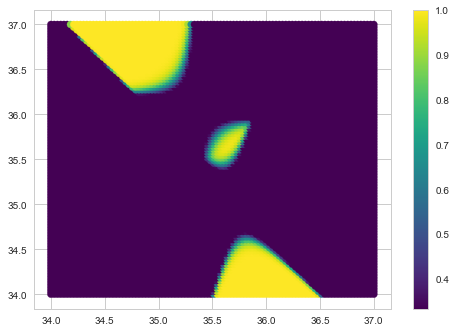

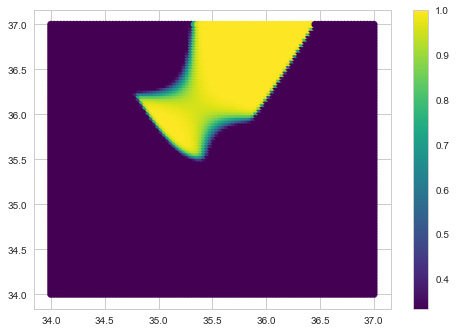

In [455]:
for ik in np.arange(K):
    fig,ax=plt.subplots(nrows=1)
    sc=ax.scatter(D_new[:,0],D_new[:,1],c=posts_new[:,ik],cmap='viridis',vmin=1./K,vmax=1.)
    plt.colorbar(sc)

# Ellipses

In [456]:
def plot_GMMellipse0(gmm,id,ik,col,ax,label=""):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 dimensions (id) 
        of the GMM model gmm
        This is the class routine, using the matplotlib Ellipse method
        I don't like it because the Ellipse object cannot be labelled...
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi 
    v = 2. * np.sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[ik,(id[0],id[1])], v[0], v[1],180 + angle,\
                                         fill=False,label=label)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(1)
    ell.set_label("Class #%i"%(ik))
#    ell.set_facecolor(color)
    ell.set_edgecolor(col)
    ell.set_linewidth(2)
    ax.add_artist(ell)
    return ell,ax

def plot_GMMellipse(gmm,id,ik,col,ax,label="",std=[1],main_axes=True,**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
    d = np.diag(d)
    theta = np.arange(0,2*np.pi,0.02)
    x = np.sqrt(d[0,0])*np.cos(theta)
    y = np.sqrt(d[1,1])*np.sin(theta)
    xy = np.array((x,y)).T
    ii = 0
    for nstd in np.array(std):
        ii+=1
        ellipse = np.inner(v,xy).T
        ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
        if ii == 1:
#            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s (%i-std)")%(label,nstd),**kwargs)
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s")%(label),**kwargs)
        else:
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax,**kwargs)
    if main_axes: # Add Main axes:
        for idir in range(2):
            l = np.sqrt(d[idir,idir])*v[:,idir].T
            start = gmm.means_[ik,(id[0],id[1])]-l
            endpt = gmm.means_[ik,(id[0],id[1])]+l
            linex = [start[0], endpt[0]]
            liney = [start[1], endpt[1]]
            plt.plot(linex,liney,color=col,axes=ax)
    return p,ax

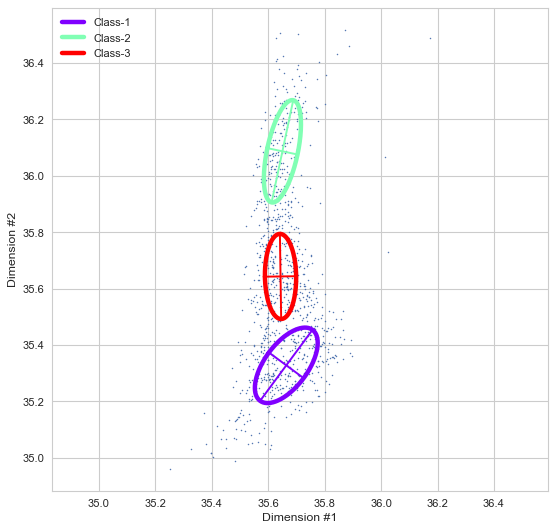

In [486]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(D1[:,id[0]],D1[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
#colors = mpl.colors.cnames.items()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
#    el,ax = plot_GMMellipse0(gmm,id,ik,colors[ik][0],ax,label="Class-%i"%(ik+1))
    el,ax = plot_GMMellipse(gmm1,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
#    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),std=[1],linewidth=4)
ax.legend(loc='upper left')
plt.show()

# Plot class on map

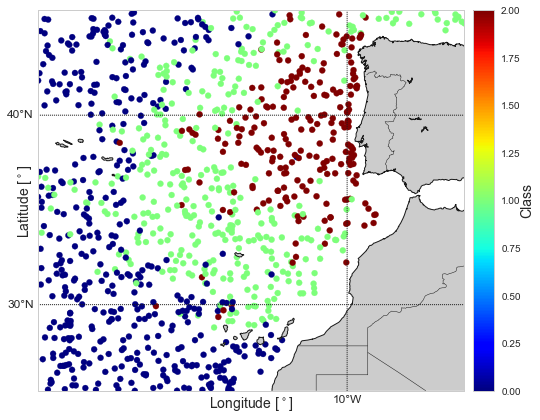

In [458]:
plt.figure(figsize=(9,7))
map = Basemap(llcrnrlon=LON_new1.min(),llcrnrlat=LAT_new1.min(),urcrnrlon=LON_new1.max(),urcrnrlat=LAT_new1.max(),
resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(20,90,10)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(-90,40,20)
map.drawmeridians(meridians,labels=[True,False,False,True])
x,y=map(LON_new1,LAT_new1)
sc=map.scatter(x,y,PSAL_new1[:,-1],c=labels1,cmap='jet')
cbar = map.colorbar(sc,location='right')
cbar.set_label("Class", labelpad=-1,fontsize=14)
plt.xlabel('Longitude [$^\circ$]',Fontsize=14)
plt.ylabel('Latitude [$^\circ$]',Fontsize=14)
plt.xticks()
plt.show()

# Second dataset

In [459]:
TIME2=nc2.variables['TIME'][:]
LAT2=nc2.variables['LATITUDE'][:]
LON2=nc2.variables['LONGITUDE'][:]
PSAL2=nc2.variables['PSAL'][:]

idx2=np.where((LAT2<lat_max) & (LAT2>lat_min) & (LON2<lon_max) & (LON2>lon_min))
LAT_new2=LAT2[idx2]
LON_new2=LON2[idx2]
PSAL_new2=PSAL2[idx2]

nb2=idx2[0].shape[0]

D2=np.array((PSAL_new2[:,z_idx1],PSAL_new2[:,z_idx2])).T

On garde le premier entrainement gmm1

In [461]:
# Get the posteriors
posts2=gmm1.predict_proba(D2)
print(posts2.shape)

# get the class maximising the posteriors (hard classif):
labels2=gmm1.predict(D2)
print(labels2.shape)

# Compute robustness of the classification
robust2=(np.max(posts2,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id2=np.digitize(robust2,Plist)-1

i_sample=np.random.randint(0,high=D2.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts2[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts2[i_sample,:]))
print('Class id of the sample:',labels2[i_sample])

(11275, 3)
(11275,)

Posteriors for 1 sample: [[ 98.     1.99   0.  ]] in %
Sum of the posteriors: 1.0
Class id of the sample: [0]


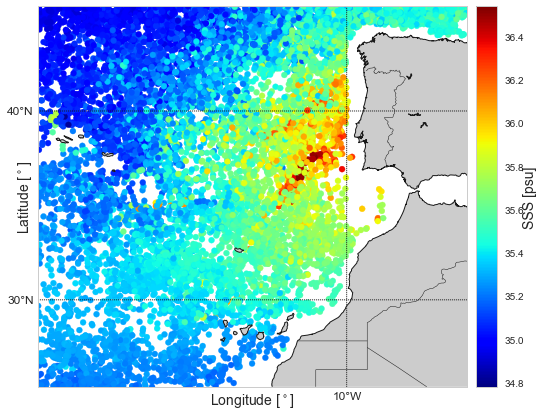

In [462]:
plt.figure(figsize=(9,7))
map = Basemap(llcrnrlon=LON_new2.min(),llcrnrlat=LAT_new2.min(),urcrnrlon=LON_new2.max(),urcrnrlat=LAT_new2.max(),
resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(20,90,10)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(-90,40,20)
map.drawmeridians(meridians,labels=[True,False,False,True])
x,y=map(LON_new2,LAT_new2)
sc=map.scatter(x,y,PSAL_new2[:,-1],c=PSAL_new2[:,-1],cmap='jet')
cbar = map.colorbar(sc,location='right')
cbar.set_label("SSS [psu]", labelpad=-1,fontsize=14)
plt.xlabel('Longitude [$^\circ$]',Fontsize=14)
plt.ylabel('Latitude [$^\circ$]',Fontsize=14)
plt.xticks()
plt.show()

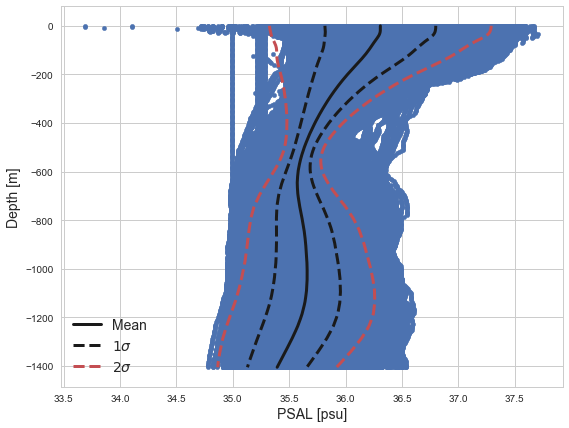

In [207]:
MEAN=np.mean(PSAL_new2[0:nb2,:],axis=0)
STD=np.std(PSAL_new2[0:nb2,:],axis=0)
col_SAL=np.linspace(PSAL_new2.min(),PSAL_new2.max(),282)

plt.figure(figsize=(9,7))
for i in range(0,nb2):
    sc=plt.scatter(PSAL_new2[i,:],z,s=20,c='b')
plt.plot(MEAN,z,linewidth=3,c='k',label='Mean')  
plt.plot(MEAN+STD,z,'--',c='k',label=r'$1\sigma$',linewidth=3)
plt.plot(MEAN-STD,z,'--',c='k',linewidth=3) 
plt.plot(MEAN+2*STD,z,'--',c='r',label=r'$2\sigma$',linewidth=3) 
plt.plot(MEAN-2*STD,z,'--',c='r',linewidth=3) 
plt.legend(fontsize=14)
plt.xlabel('PSAL [psu]',fontsize=14)
plt.ylabel('Depth [m]',fontsize=14)
plt.show()

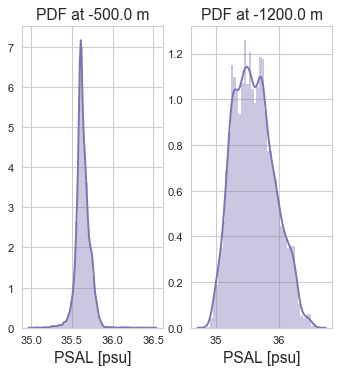

In [463]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", palette="deep", color_codes=True)
plt.subplot(121)
sns.distplot(PSAL_new2[:,z_idx1], norm_hist=True, color="m")
plt.xlabel('PSAL [psu]',fontsize=14)
plt.title('PDF at '+str(z[z_idx1])+' m',fontsize=14)

plt.subplot(122)
sns.distplot(PSAL_new2[:,z_idx2], norm_hist=True, color="m")
plt.xlabel('PSAL [psu]',fontsize=14)
plt.title('PDF at '+str(z[z_idx2])+' m',fontsize=14)
plt.show()

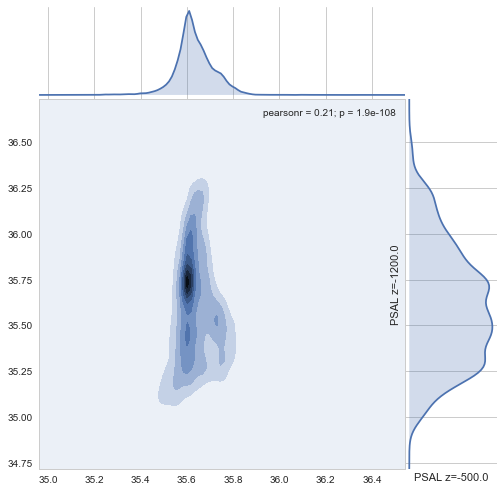

In [464]:
x = PSAL_new2[:,z_idx1]
y = PSAL_new2[:,z_idx2]
sns.set(context="notebook",style="whitegrid", color_codes=True)
sns.jointplot(x=x, y=y, kind="kde",size=7, ratio=4, space=0)
plt.xlabel('PSAL z='+str(z[z_idx1]))
plt.ylabel('PSAL z='+str(z[z_idx2]))
plt.show()

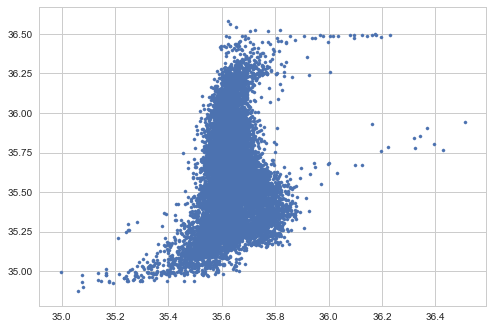

In [465]:
plt.scatter(D2[:,0],D2[:,1],s=10)
plt.show()

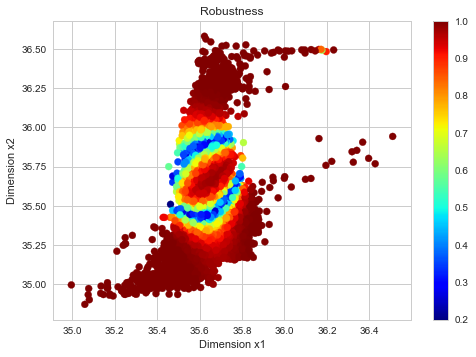

In [466]:
plt.scatter(D2[:,0],D2[:,1],c=robust2,cmap='jet')
plt.colorbar()
plt.title('Robustness')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

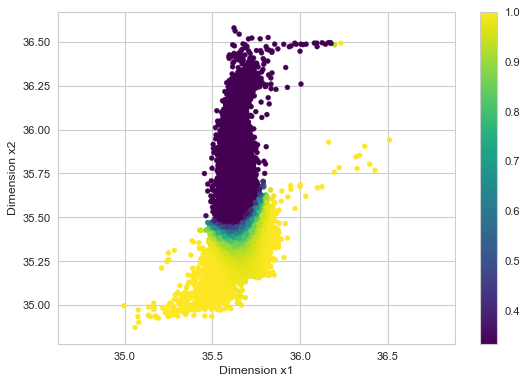

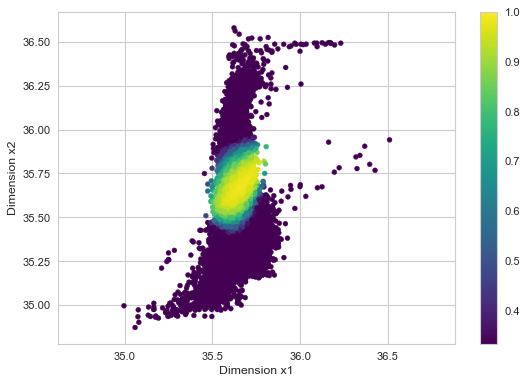

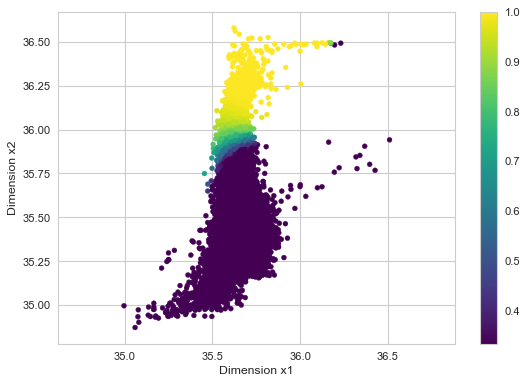

In [467]:
for ik in np.arange(K):
    fig,ax=plt.subplots(nrows=1,ncols=1,dpi=80,facecolor='w',edgecolor='k',sharey=True)
    
    sc=ax.scatter(D2[:,0],D2[:,1],c=posts2[:,ik],s=20,cmap='viridis',vmin=1./K,vmax=1)
    plt.axis('equal')
    plt.colorbar(sc)
    plt.xlabel('Dimension x1')
    plt.ylabel('Dimension x2')

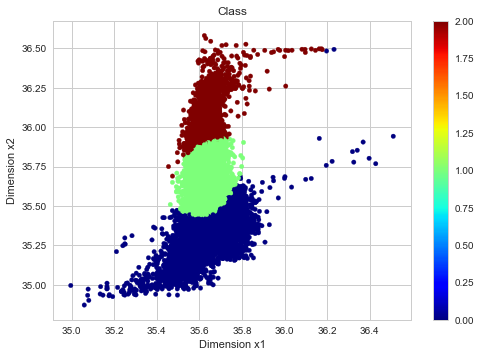

In [468]:
sc=plt.scatter(D2[:,0],D2[:,1],s=20,c=labels2,cmap='jet')
plt.colorbar(sc)
plt.title('Class')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

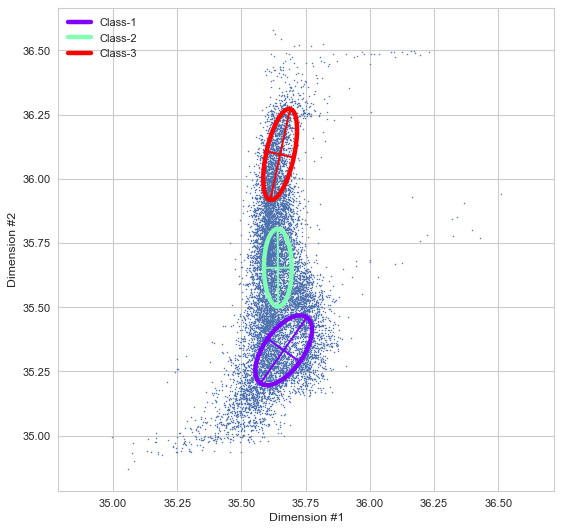

In [469]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(D2[:,id[0]],D2[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
    el,ax = plot_GMMellipse(gmm1,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
ax.legend(loc='upper left')
plt.show()

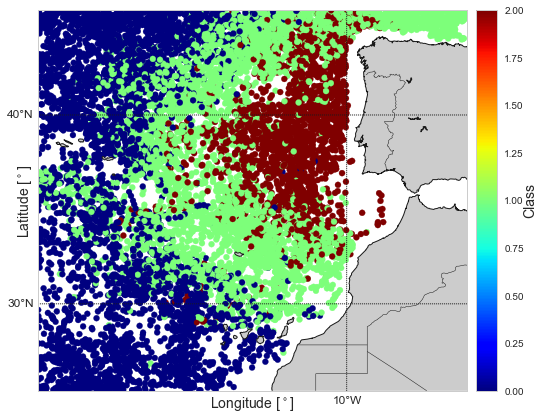

In [471]:
plt.figure(figsize=(9,7))
map = Basemap(llcrnrlon=LON_new2.min(),llcrnrlat=LAT_new2.min(),urcrnrlon=LON_new2.max(),urcrnrlat=LAT_new2.max(),
resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(20,90,10)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(-90,40,20)
map.drawmeridians(meridians,labels=[True,False,False,True])
x,y=map(LON_new2,LAT_new2)
sc=map.scatter(x,y,PSAL_new2[:,-1],c=labels2,cmap='jet')
cbar = map.colorbar(sc,location='right')
cbar.set_label("Class", labelpad=-1,fontsize=14)
plt.xlabel('Longitude [$^\circ$]',Fontsize=14)
plt.ylabel('Latitude [$^\circ$]',Fontsize=14)
plt.xticks()
plt.show()

## MERGE all data

In [391]:
NCFILE = './NATL_HOMOGENEOUS_variables_7subset_'

TIME_TOT=[]
LAT_TOT=[]
LON_TOT=[]


for i in range(1,8):
    NAME=NCFILE+str(i)+'.nc'
    NC = Dataset(NAME, 'r')
    TIME=NC.variables['TIME'][:]
    TIME_TOT=np.concatenate((TIME_TOT,TIME),axis=0)
    LAT=NC.variables['LATITUDE'][:]
    LAT_TOT=np.concatenate((LAT_TOT,LAT),axis=0)
    LON=NC.variables['LONGITUDE'][:]
    LON_TOT=np.concatenate((LON_TOT,LON),axis=0)
    z=NC.variables['DEPTH'][:]
    PSAL=NC.variables['PSAL'][:]
    if(i==1):
        PSAL_TOT=np.zeros((PSAL.shape[0],PSAL.shape[1]))
    PSAL_TOT=np.concatenate((PSAL_TOT,PSAL),axis=0)
    
#PSAL_TOT=PSAL_TOT[PSAL.shape[0]:,:]    

# Learning the model with the big dataset

In [491]:
K=3
gmm3=mixture.GaussianMixture(n_components=K)
g3mm=gmm3.fit(D2)

print(gmm3.score(D2))

k=0
for pos3, covar3, w3 in zip(gmm3.means_,gmm3.covariances_,gmm3.weights_):
    print('\nMode/Class/Component/Cluster ID#',k)
    print('Center:\n',pos)
    print('Covariance:\n',covar)
    print('Weight (prior):\n',w)
    k=k+1

1.01387858087

Mode/Class/Component/Cluster ID# 0
Center:
 [ 35.62792292  35.65325546]
Covariance:
 [[ 0.00252654  0.00055713]
 [ 0.00055713  0.02439907]]
Weight (prior):
 0.370393960766

Mode/Class/Component/Cluster ID# 1
Center:
 [ 35.62792292  35.65325546]
Covariance:
 [[ 0.00252654  0.00055713]
 [ 0.00055713  0.02439907]]
Weight (prior):
 0.370393960766

Mode/Class/Component/Cluster ID# 2
Center:
 [ 35.62792292  35.65325546]
Covariance:
 [[ 0.00252654  0.00055713]
 [ 0.00055713  0.02439907]]
Weight (prior):
 0.370393960766


In [473]:
posts3=gmm3.predict_proba(D2)
print(posts3.shape)

labels3=gmm3.predict(D2)
print(labels3.shape)

robust3=(np.max(posts3,axis=1)-1./K)*K/(K-1.)
Plist=[0,.33,.66,.9,.99,1];
row10=('Unlikely','As likely as not','Likely','Very Likely','Virtually certain')
robust_id3=np.digitize(robust3,Plist)-1

i_sample=np.random.randint(0,high=D2.shape[0],size=(1,))
print('\nPosteriors for 1 sample:',np.round(posts3[i_sample,:]*100,2),'in %')
print('Sum of the posteriors:',np.sum(posts3[i_sample,:]))
print('Class id of the sample:',labels3[i_sample])

(11275, 3)
(11275,)

Posteriors for 1 sample: [[  0.    89.11  10.89]] in %
Sum of the posteriors: 1.0
Class id of the sample: [1]


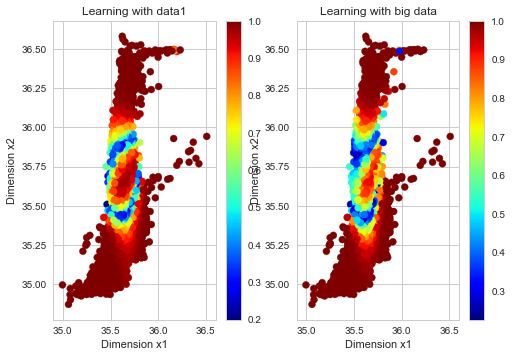

In [474]:
plt.figure()
plt.subplot(121)
plt.title('Learning with data1')
plt.scatter(D2[:,0],D2[:,1],c=robust2,cmap='jet')
plt.colorbar()
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')

plt.subplot(122)
plt.title('Learning with big data')
plt.scatter(D2[:,0],D2[:,1],c=robust3,cmap='jet')
plt.colorbar()
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

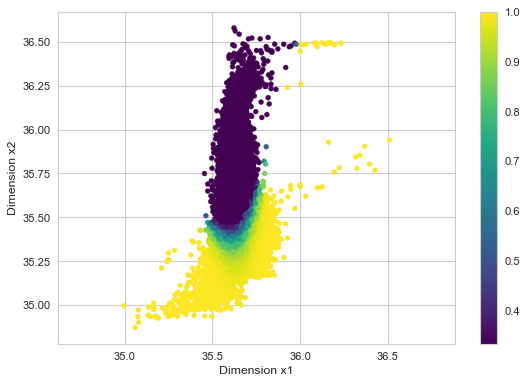

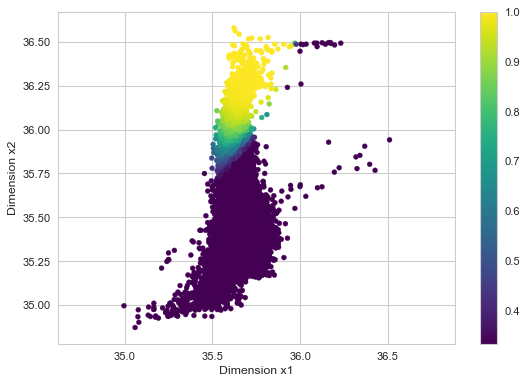

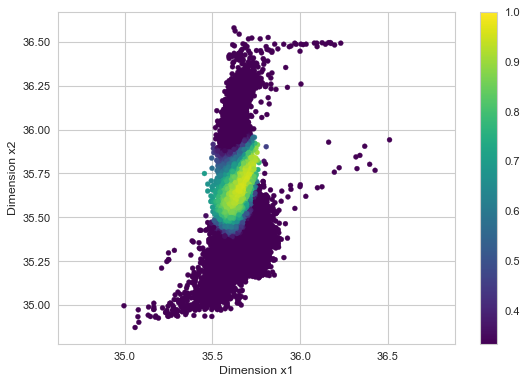

In [475]:
for ik in np.arange(K):
    fig,ax=plt.subplots(nrows=1,ncols=1,dpi=80,facecolor='w',edgecolor='k',sharey=True)
    sc=ax.scatter(D2[:,0],D2[:,1],c=posts3[:,ik],s=20,cmap='viridis',vmin=1./K,vmax=1)
    plt.axis('equal')
    plt.colorbar(sc)
    plt.xlabel('Dimension x1')
    plt.ylabel('Dimension x2')

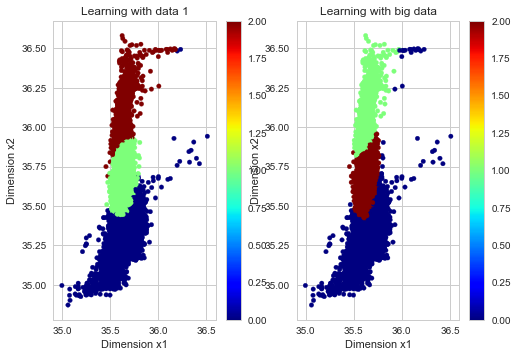

In [476]:
plt.figure()
plt.subplot(121)
sc=plt.scatter(D2[:,0],D2[:,1],s=20,c=labels2,cmap='jet')
plt.colorbar(sc)
plt.title('Learning with data 1')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')

plt.subplot(122)
sc=plt.scatter(D2[:,0],D2[:,1],s=20,c=labels3,cmap='jet')
plt.colorbar(sc)
plt.title('Learning with big data')
plt.xlabel('Dimension x1')
plt.ylabel('Dimension x2')
plt.show()

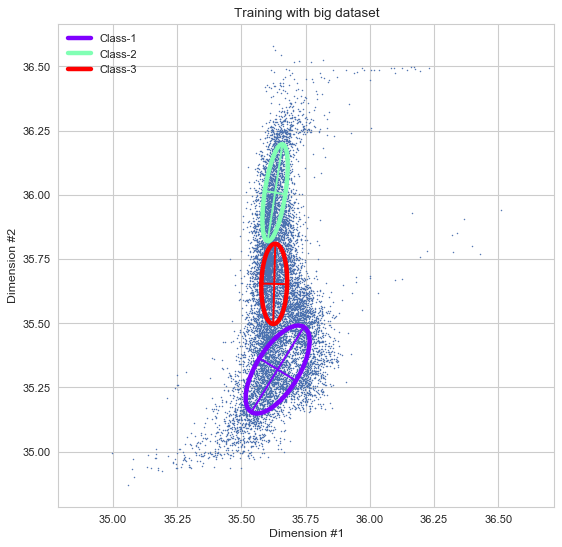

In [479]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(D2[:,id[0]],D2[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
    el,ax = plot_GMMellipse(gmm3,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
ax.legend(loc='upper left')
plt.title('Training with big dataset')
plt.show()

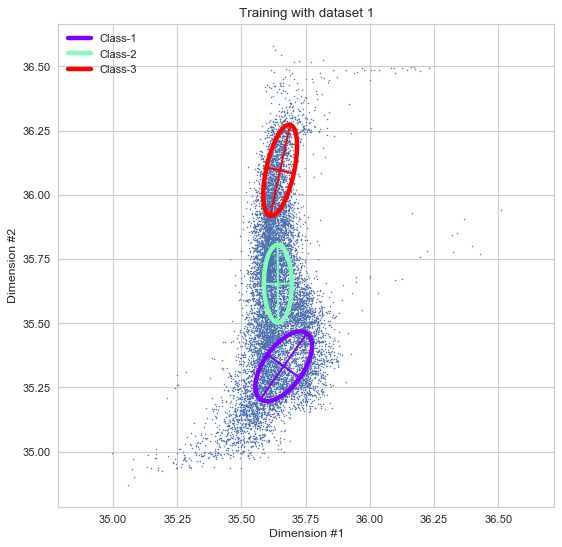

In [482]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(D2[:,id[0]],D2[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
    el,ax = plot_GMMellipse(gmm1,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
ax.legend(loc='upper left')
plt.title('Training with dataset 1')
plt.show()